# ShEx

This document contains a short introduction to ShEx using [rudof](https://rudof-project.github.io/). 


## Install and configure rudof

The library is available as `pyrudof`.

In [1]:
!pip install pyrudof

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 23.2 MB/s eta 0:00:00


The main entry point if a class called `Rudof` through which most of the functionality is provided.

In [2]:
from pyrudof import Rudof, RudofConfig

In order to initialize that class, it is possible to pass a RudofConfig instance which contains configuration parameters for customization.

In [3]:
rudof = Rudof(RudofConfig())

## Validate using ShEx

In [17]:
rudof.read_shex_str("""
prefix : <http://example.org/>
prefix xsd:    <http://www.w3.org/2001/XMLSchema#>

:Person {
 :name xsd:string
}
""")


In [18]:
rudof.read_data_str("""
prefix : <http://example.org/>

:ok :name "alice" .
:ko :name 1 .
""")

In [19]:
rudof.read_shapemap_str(":ok@:Person, :ko@:Person")

Once the ShEx schema and the Shapemap have been added to `rudof`, it is possible to validate the current RDF data with the `validate_shex()` method:

In [22]:
results = rudof.validate_shex()

`validate_shex()` returns a `ResultShapeMap` object which contains a `show()` method to show the results of the validation:

In [23]:
for (node, shape, status) in results.to_list():
    print(f"Node: {node.show()}")
    print(f"Shape: {shape.show()}")
    print(f"Conformant?: {status.is_conformant()}")
    print(f"Appinfo: {status.as_json()}")
    print("")


Node: http://example.org/ok
Shape: http://example.org/Person
Conformant?: True
Appinfo: {'info': [{'reason': 'Shape passed. Node http://example.org/ok, shape 0: Shape  Preds: http://example.org/name, TripleExpr: RBE [C0], Keys: [http://example.org/name -> {C0}], conds: [C0 -> xsd:string], References: []'}], 'reason': 'Shape passed. Node :ok, shape 0: :Person = {:name xsd:string}\n', 'status': 'conformant'}

Node: http://example.org/ko
Shape: http://example.org/Person
Conformant?: False
Appinfo: {'info': [{'error': 'Datatype error: Datatype expected http://www.w3.org/2001/XMLSchema#string but found http://www.w3.org/2001/XMLSchema#integer for literal with lexical form 1'}], 'reason': 'Error Datatype error: Datatype expected http://www.w3.org/2001/XMLSchema#string but found http://www.w3.org/2001/XMLSchema#integer for literal with lexical form 1\n', 'status': 'nonconformant'}



We reset the status of the `ShEx` schema, the `Shapemap` and the current `RDF data` for the next section.

In [24]:
rudof.reset_all()

## Converting ShEx to UML

`rudof` can be used to convert ShEx to diagrams in UML-like style. The converter generates a [PlantUML](https://plantuml.com/) string which can be written to a file and converted to an image using the PlantUML tool.

In [25]:
from pyrudof import UmlGenerationMode

In [27]:
rudof.read_shex_str("""
prefix : <http://example.org/>
prefix xsd:    <http://www.w3.org/2001/XMLSchema#>

:User {
 :name     xsd:string  ;
 :worksFor @:Company * ;
 :addres   @:Address   ;
 :knows    @:User
}

:Company {
  :name     xsd:string     ;
  :code     xsd:string     ;
  :employee @:User
}
:Address {
  :name     xsd:string ;
  :zip_code xsd:string
}
""")

In [28]:
plant_uml = rudof.shex2plantuml_file(UmlGenerationMode(), 'out.puml')

Now we install the PlantUML tools necessary to process the generated `plant_uml`

In [29]:
! pip install plantuml

In [30]:
! pip install ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.8 MB/s eta 0:00:00


In [31]:
!python -m plantuml out.puml

[{'filename': 'out.puml', 'gen_success': True}]


In [32]:
from IPython.display import Image

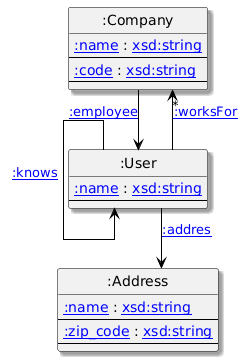

In [33]:
Image(f"out.png")

In [34]:
rudof.reset_all()

## Converting DCTAP to ShEx

Rudof can be used to convert [DCTAP](https://www.dublincore.org/specifications/dctap/) files to ShEx.

DCTAP can be used to represent shapes using a tabular representation using CSV or an spreadsheet format like XLSX. As an example, the following CSV data:


In [35]:
dctap_str = """shapeId,propertyId,Mandatory,Repeatable,valueDatatype,valueShape
Person,name,true,false,xsd:string,
,birthdate,false,false,xsd:date,
,worksFor,false,true,,Company
Company,name,true,false,xsd:string,
,employee,false,true,,Person
"""

In [36]:
rudof.read_dctap_str(dctap_str)

In [37]:
dctap = rudof.get_dctap()

In [38]:
print(dctap)

Shape(Person)  
 name xsd:string 
 birthdate xsd:date ?
 worksFor @Company *
Shape(Company)  
 name xsd:string 
 employee @Person *



It is possible to convert the DCTAP obtained to ShEx

In [39]:
rudof.dctap2shex()


In [40]:
from pyrudof import ShExFormatter

In [41]:
shex = rudof.get_shex()

result = rudof.serialize_shex(shex, ShExFormatter())


In [42]:
print(result)

prefix sh: <http://www.w3.org/ns/shacl#>
prefix : <http://example.org/>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix dc: <http://purl.org/dc/elements/1.1/>
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
:Person { :name xsd:string; :birthdate xsd:date ?; :worksFor @:Company * }
:Company { :name xsd:string; :employee @:Person * }
